# Targeting free energies 

In [1]:
import sys
sys.path.insert(0,'../')
from DescriptorDOS import DDOSAnalyzer

import numpy as np
import matplotlib.pyplot as plt

**Load reference potential**
- We load the reference SNAP potential used for Fe


In [2]:
mass = 55.85
ThetaRef = np.loadtxt(f'sample_data/X_Fe.snapcoeff',skiprows=6) # scrape just the coefficients
Thetas = ThetaRef.copy().reshape((1,-1))

**Load DDOS samples and reference potential**
- For ease-of-use we only include a single volume in the loaded dataset for these examples
- The NVT free energies were chosen to give essentially identical results to the NPT study from the paper

In [3]:
# BCC Fe data
DDOS_pkl_file = 'sample_data/Fe_bcc_444_Hessian_single_vol.pkl'
V0 = 9.721286694395822
H_D_BCC = DDOSAnalyzer(DDOS_pkl_file,volume_per_atom=V0,verbose=False,mass=mass)
E_0_BCC = H_D_BCC.cohesive_energy(Thetas=Thetas)[0];

# FCC Fe data 
V0 = 10.380756139744738
DDOS_pkl_file = 'sample_data/Fe_fcc_333_Hessian_single_vol.pkl'
H_D_FCC = DDOSAnalyzer(DDOS_pkl_file,volume_per_atom=V0,verbose=False,mass=mass)
E_0_FCC = H_D_FCC.cohesive_energy(Thetas=Thetas)[0];


**Score matching**
We store the T=0K energy difference and perform the score matching fit with a order 7 polynomial (see paper)





In [4]:
dE_0 = E_0_FCC-E_0_BCC
Temperatures = np.linspace(500,2500,31)
print("Matching score model for FCC and BCC")
%time H_D_FCC.match_score(poly_order=7,poly_type='chebyshev')
H_D_BCC.match_score(poly_order=7,poly_type='chebyshev')

# let's calculate the free energy across 31 temperatures for both BCC and FCC. Sub millisecond per temperature
print("Predicting free energies for FCC and BCC across 31 temperatures")
%time F_0_FCC = np.array([H_D_FCC.score_free_energy(Temperature=T,Thetas=Thetas)['F'] for T in Temperatures])
F_0_BCC = np.array([H_D_BCC.score_free_energy(Temperature=T,Thetas=Thetas)['F'] for T in Temperatures])
    

Matching score model for FCC and BCC
CPU times: user 73.7 ms, sys: 24.1 ms, total: 97.9 ms
Wall time: 97.7 ms
Predicting free energies for FCC and BCC across 31 temperatures
CPU times: user 14.4 ms, sys: 2.26 ms, total: 16.6 ms
Wall time: 16.7 ms


Function which evaluates the free energy difference and gradient of that difference for a given parameter value

In [5]:


def free_energy_and_gradient(Theta,Tc=1063,dense=False):
        
        res = H_D_FCC.score_free_energy(Temperature=Tc,Thetas=Theta.reshape((1,-1)),return_D=True)
        dF = res['F'][0] + dE_0
        dD = res['D']


        res = H_D_BCC.score_free_energy(Temperature=Tc,Thetas=Theta.reshape((1,-1)),return_D=True)
        dF -= res['F'][0]
        dD -= res['D']
        
        # Free energy difference and gradient
        return dF,dD.flatten()

Function which evaluates the phase transition temperature for a given parameter value

In [6]:

def transition_temperature(Theta,dense=False):
    F_key = 'dense_F' if dense else 'F'
    dF = np.array([H_D_FCC.score_free_energy(Temperature=T,Thetas=Theta.reshape((1,-1)))[F_key] for T in Temperatures])
    dF -= np.array([H_D_BCC.score_free_energy(Temperature=T,Thetas=Theta.reshape((1,-1)))[F_key] for T in Temperatures])
    dF += dE_0
    
    if dF.max()>0.0 and dF.min() < 0.0:
        first_ne = (dF<0).argmax()
        T_l = Temperatures[first_ne-1]
        T_r = Temperatures[first_ne]
        F_l = dF[first_ne-1]
        F_r = dF[first_ne]

        return (T_l-T_r)*F_l/(F_r-F_l) + T_l
    return Temperatures.max()


**Optimization procedure**

As a cheap simulator of regularizing against training data for this test example we simply have a ridge 
regularization against the initial parameter value ${\bf w}_0$ (same minimum, different curvature),
which gaves sufficiently similar results for this test. Our loss function reads, with ridge strength $r$
$$
\mathcal{L}({\bf w})
=
\|T^{\rm ref}_c-T_c({\bf w})\|^2
+
r\|{\bf w}-{\bf w}_0\|^2
$$

We ensure the T=0K energy difference $\Delta E^{\alpha-\gamma}_{\bf w}$ is constant throughout the optimization. 
To do this, we use the descriptor difference $\Delta{\bf D}_0^{\alpha-\gamma}$ to build a rank-one projector
$$
{\bf P}_0\equiv \frac{\Delta{\bf D}_0^{\alpha-\gamma}\otimes\Delta{\bf D}_0^{\alpha-\gamma}}{\Delta{\bf D}_0^{\alpha-\gamma}\cdot\Delta{\bf D}_0^{\alpha-\gamma}}.
$$

Gradient updates then subtract then follow, with step size $\delta_w$
$$
{\bf w}\leftarrow {\bf w} - \delta_w\left(\mathbb{I}-{\bf P}_0\right)
\boldsymbol{\nabla}_{\bf w}\mathcal{L}({\bf w})
$$

In [7]:
tuned_Theta = ThetaRef.copy() # initial value

# optimization steps
dw = 2.5e-5
regularizer = 5.
steps = 20
dD_0 = H_D_FCC.D_0-H_D_BCC.D_0
P_0 = np.outer(dD_0,dD_0)/np.linalg.norm(dD_0)**2




dF,dD = free_energy_and_gradient(tuned_Theta)
dF_traj = np.array([dF])

T_traj = np.array([transition_temperature(tuned_Theta)])

Theta_traj = tuned_Theta.reshape((1,-1))

# loss is |dF|^2 + regularizer * |dD|^2

for step in range(steps):
    loss_gradient = dF*dD 
    loss_gradient += regularizer * (tuned_Theta-ThetaRef.copy())
    loss_gradient -= P_0@loss_gradient
    tuned_Theta -= dw*loss_gradient

    dF,dD = free_energy_and_gradient(tuned_Theta)
    
    dF_traj = np.append(dF_traj,dF)
    
    T_traj = np.append(T_traj,transition_temperature(tuned_Theta))    
    Theta_traj = np.append(Theta_traj,tuned_Theta.reshape((1,-1)),axis=0)

Plotting the final result

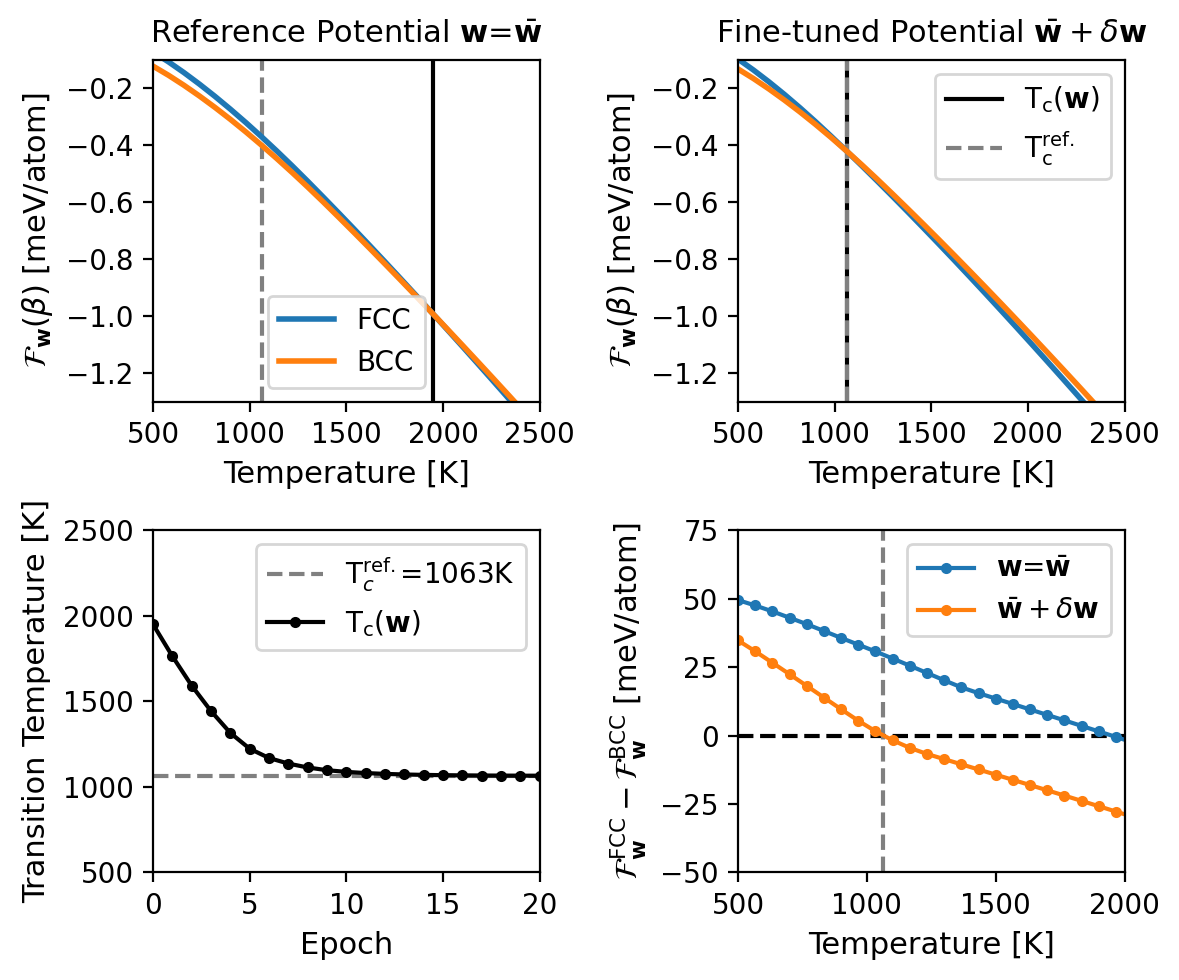

In [8]:
fs = 10
fig, aaxs = plt.subplots(2,2,figsize=(6,5),dpi=200)


axs = aaxs[0]

axs[1].axvline(1063.,c='k',ls='-',label=r'${\rm T_c}({\bf w})$')
axs[0].axvline(T_traj[0],c='k',ls='-')

axs[1].axvline(1063.,c='gray',ls='--',label=r'${\rm T^{\rm ref.}_c}$')
axs[0].axvline(1063.,c='gray',ls='--')


axs[0].set_ylim(-1.3,-0.1)
axs[1].set_ylim(-1.3,-0.1)

axs[0].set_xlim(500,2500)
axs[1].set_xlim(500,2500)

NewTemp = np.linspace(100,2500,31)
for ii,Thetas in  enumerate([ThetaRef,tuned_Theta]):
    Thetas = Thetas.reshape((1,-1))
    A_FCC = [H_D_FCC.score_free_energy(Temperature=T,Thetas=Thetas) for T in NewTemp]
    A_BCC = [H_D_BCC.score_free_energy(Temperature=T,Thetas=Thetas) for T in NewTemp]

    F_FCC = (np.array([_A['F'] for _A in A_FCC])) #* 1000.
    F_BCC = (np.array([_A['F'] for _A in A_BCC])- dE_0) #* 1000.
    axs[ii].plot(NewTemp,F_FCC,f'-',label=r'FCC' if ii==0 else None,lw=2)
    axs[ii].plot(NewTemp,F_BCC,f'-',label=r'BCC' if ii==0 else None,lw=2) #  ($\epsilon=$1.0%)

    axs[ii].set_ylabel(r"$\mathcal{F}_{{\bf w}}(\beta)$ [meV/atom]",fontsize=fs+1)
    axs[ii].set_xlabel("Temperature [K]",fontsize=fs+1)  

axs[0].legend(fontsize=fs,loc='lower center')
axs[1].legend(fontsize=fs,loc='upper right')

axs[0].set_title(r"Reference Potential ${\bf w}$=$\bar{\bf w}$",fontsize=fs+1)
axs[1].set_title(r"Fine-tuned Potential $\bar{\bf w}+\delta{\bf w}$",fontsize=fs+1)


axs = aaxs[1,::-1]
axs[0].axhline(0.0,c='k',ls='--')
axs[0].axvline(1063,c='gray',ls='--')
axs[1].axhline(1063,c='gray',ls='--',label=r'${\rm T}^{\rm ref.}_c$=1063K')


for ii,Thetas in  enumerate([ThetaRef,tuned_Theta]):
    Thetas = Thetas.reshape((1,-1))
    A_FCC = [H_D_FCC.score_free_energy(Temperature=T,Thetas=Thetas) for T in Temperatures]
    A_BCC = [H_D_BCC.score_free_energy(Temperature=T,Thetas=Thetas) for T in Temperatures]

    F_FCC = (np.array([_A['F'] for _A in A_FCC]) + dE_0) * 1000. # we define score_free_energy to be 0 at T=0K
    F_BCC = np.array([_A['F'] for _A in A_BCC]) * 1000.

    axs[0].plot(Temperatures,F_FCC-F_BCC,f'.-',label=r'${\bf w}$=$\bar{\bf w}$' if ii==0 else r'$\bar{\bf w}+\delta{\bf w}$')

    
axs[0].set_ylabel(\
            r"$\mathcal{F}^{\rm FCC}_{{\bf w}}-\mathcal{F}^{\rm BCC}_{{\bf w}}$ [meV/atom]",fontsize=fs+1)
axs[0].set_xlabel("Temperature [K]",fontsize=fs+1)  


epochs = np.arange(steps+1)
axs[1].set_ylabel("Transition Temperature [K]",fontsize=fs+1) 

axs[1].plot(epochs[T_traj>0.0],T_traj[T_traj>0.0],'.-',color='k',label=r"${\rm T_c}({\bf w})$")

axs[1].set_ylim(500,2500)
axs[1].set_xlim(0,20)
axs[0].set_xlim(500,2000)
axs[0].set_ylim(-50,75)
axs[1].set_xlabel("Epoch",fontsize=fs+1)  
axs[0].legend(fontsize=fs,loc='upper right')
axs[1].legend(fontsize=fs,loc='upper right')


plt.tight_layout()



